# Experiments

Last Updated: 04/26/2022

Evaluating instance-level explanations.
Note: we are only mining rules to explain the positive instances.
- explainers
    - anchor
    - TE2Rule
- metrics
    - precision (positive_support/decision_support)
    - recall (positive_support/num_positive_points)
    - coverage (decision_support/num_points)
    - compute time per instance

TODO:
- compare against SHAP value

In [1]:
# 0. Construct TE2Rule and anchor explainers for a trained GBM model
# 1. sample n positive instances from the dataset 
# 2. for each instance, obtain anchor & TE2Rule (rule, computation time)
# 3. evaluate precision/recall/coverage at dataset-level
# 4. obtain shap value matrix & rule-triggering matrix (num_instances * num_variables)

# plot:
# TE2 dataset precision vs anchor dataset fidelity per rule
# TE2 dataset recall vs anchor dataset fidelity per rule
# TE2 dataset coverage vs anchor dataset coverage per rule
# compute time of rule-extraction
# shap value: triggered variable heatmap vs shap heatmap; similarity score

# function: rule-triggering matrix + a shap value matrix ⇒ 
# rule triggering heatmap comparison, cosine similarity of the two matrics

In [68]:
# load packages
# pip install anchor-exp
from sklearn.ensemble import GradientBoostingClassifier
from lib.trainer import Trainer
from lib.adapter import ScikitTreeAdapter, ScikitForestAdapter
from train import pipeline
from sklearn.tree import export_text
from lib.rule import Rule
import numpy as np
import pandas as pd
from anchor import utils
from anchor import anchor_tabular
import matplotlib.pyplot as plt
import shap
import lime
import time

In [94]:
# 0. Construct TE2Rule and anchor explainers for a trained GBM model
# Obtain TE2Rule Global rules
solutions, trainer, te2_rule_precision_list, te2_rule_recall_list, te2_rule_coverage_list = pipeline(
    training_data_path="data/train.csv", 
    testing_data_path="data/test.csv", 
    num_estimators=10,
    fidelity_threshold=1
)

te2_global_rule_list = np.array([s.decision_rule for s in solutions])

df = pd.DataFrame(trainer.x_train, columns=trainer.feature_names)
df['y_pred'] = trainer.model.predict(trainer.x_train)

# construct anchor explainer
anchor_explainer = anchor_tabular.AnchorTabularExplainer(
    class_names=['negative', 'positive'],
    feature_names=trainer.feature_names,
    train_data=trainer.x_train,
    categorical_names={}
)

XGBoost Model
Accuracy
0.8176904176904177
AUC
0.6160302162448409
10 trees

Rules from trees

150 candidates
Merging candidates...
74 candidates

Running Apriori

Stage 0
Pruning Candidates

23 candidates
2 solutions
Merging candidates and solutions...
23 candidates
2 solutions

Fidelity
Total: 0.9866400491400491, Positive: 0.7772657450076805, Negative: 1.0
Unexplained Positives
435

Stage 1
Pruning Candidates

112 candidates
4 solutions
Merging candidates and solutions...
65 candidates
4 solutions

Fidelity
Total: 0.9958845208845208, Positive: 0.9313876088069637, Negative: 1.0
Unexplained Positives
134

Stage 2
Pruning Candidates

143 candidates
5 solutions
Merging candidates and solutions...
75 candidates
5 solutions

Fidelity
Total: 0.9960995085995086, Positive: 0.9349718381976446, Negative: 1.0
Unexplained Positives
127

Stage 3
Pruning Candidates

0 candidates
6 solutions
Merging candidates and solutions...
0 candidates
6 solutions

Fidelity
Total: 1.0, Positive: 1.0, Negative: 1.0

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# 1. sample n positive instances from the dataset
sample_df = df[df.y_pred==True].sample(10, random_state=0)
explained_te2_instance_indices = []
te2_rule_list, anchor_rule_list = [], []
te2_time_list, anchor_time_list = [], []
te2_precision_list, anchor_precision_list = [], []
te2_recall_list, anchor_recall_list = [], []
te2_coverage_list, anchor_coverage_list = [], []

for i in sample_df.index:
    # 2. for each instance, obtain anchor & TE2Rule (rule, computation time)
    # te2rule
    valid_instance = False
    start_time = time.time()
    for j in range(len(te2_global_rule_list)):
        te2_rule = te2_global_rule_list[j]
        if len(sample_df.loc[[i]].query(" & ".join(te2_rule), engine='python')) > 0: # if rule predicates match instance
            te2_time_list.append(time.time() - start_time)
            te2_rule_list.append(te2_rule)
            valid_instance = True
            break
    # if TE2Rule does not find a rule for the instance, go to the next instance
    if not valid_instance:
        print("No rule found for this instance ", i)
        continue
    explained_te2_instance_indices.append(i)
   
    # anchor
    start_time = time.time()
    anchor_rule = anchor_explainer.explain_instance(
        trainer.x_train[i], trainer.model.predict, threshold=0.95, batch_size=100).names()
    anchor_rule_list.append(anchor_rule)
    anchor_time_list.append(time.time() - start_time)
    
    
    # 3. evaluate precision/recall/coverage at dataset-level
    # for te2, we only need to extract the result from the memoized lists
    te2_precision_list.append(te2_rule_precision_list[j])
    te2_recall_list.append(te2_rule_recall_list[j])
    te2_coverage_list.append(te2_rule_coverage_list[j])
    
    # for anchor, we need to query the dataset based on the rule
    anchor_rule_support = len(df.query(" & ".join(anchor_rule), engine='python'))
    anchor_rule_positive_support = len(df.query(" & ".join(anchor_rule), engine='python').query('y_pred > 0'))
    anchor_precision_list.append(anchor_rule_positive_support/anchor_rule_support)
    anchor_recall_list.append(anchor_rule_positive_support/sum(df.y_pred))
    anchor_coverage_list.append(anchor_rule_support/len(df))


In [ ]:
# 4. obtain shap value matrix & rule-triggering matrix (num_instances * num_variables)
def rules_features_saliency(rules, feature_names):
    saliency = pd.DataFrame(np.zeros([len(rules), len(feature_names)]), columns=feature_names)
    for i in range(len(rules)):
        r_str = " & ".join(rules[i])
        for f in feature_names:
            if f in r_str:
                saliency.loc[i,f] = 1
    return saliency

shap_explainer = shap.TreeExplainer(trainer.model)
shap_values = shap_explainer.shap_values(sample_df.loc[explained_te2_instance_indices, :].iloc[:,:-1])
te2_rule_triggering_list = rules_features_saliency(te2_rule_list, trainer.feature_names)
anchor_rule_triggering_list = rules_features_saliency(anchor_rule_list, trainer.feature_names)

print("Avg shap value of the variables chosen by te2 rule: ", 
      (shap_values * te2_rule_triggering_list).mean(1).mean())
print("Avg shap value of the variables chosen by anchor rule: ", 
      (shap_values * anchor_rule_triggering_list).mean(1).mean())

(0.0, 40.0)

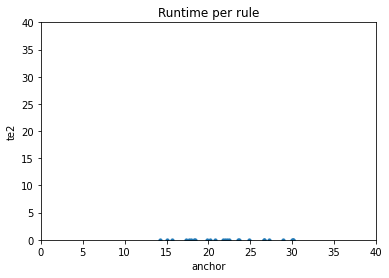

In [77]:
# plot
plt.scatter(anchor_time_list, te2_time_list, s=10)
plt.xlabel("anchor")
plt.ylabel("te2")
plt.title("Runtime per rule")
plt.xlim([0, 40])
plt.ylim([0, 40])

(0.65, 1.02)

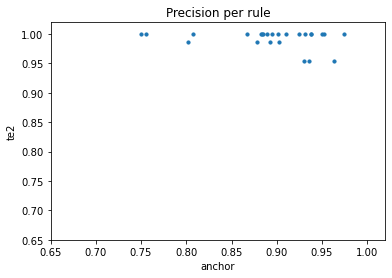

In [78]:
# plot
plt.scatter(anchor_precision_list, te2_precision_list, s=10)
plt.xlabel("anchor")
plt.ylabel("te2")
plt.title("Precision per rule")
plt.xlim([0.65, 1.02])
plt.ylim([0.65, 1.02])

(0.0, 0.66)

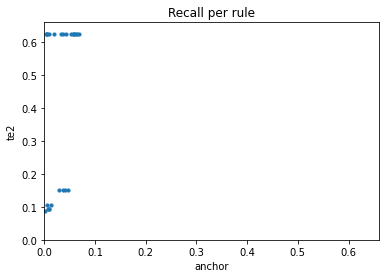

In [79]:
# plot
plt.scatter(anchor_recall_list, te2_recall_list, s=10)
plt.xlabel("anchor")
plt.ylabel("te2")
plt.title("Recall per rule")
plt.xlim([0.0, 0.66])
plt.ylim([0.0, 0.66])

(0.0, 0.05)

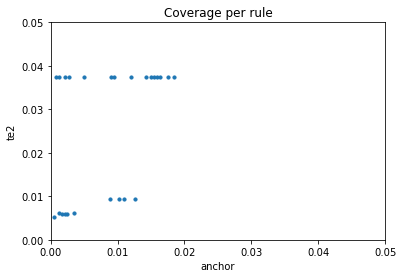

In [80]:
# plot
plt.scatter(anchor_coverage_list, te2_coverage_list, s=10)
plt.xlabel("anchor")
plt.ylabel("te2")
plt.title("Coverage per rule")
plt.xlim([0.0, 0.05])
plt.ylim([0.0, 0.05])